In [1]:
import tifffile as tf
from scipy import ndimage
import numpy as np
import pandas as pd

import os
import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

from skimage import morphology as morph

In [39]:
src = '../hpcc/'
dst = '../hpcc/traditional/'

wsrc = src + 'clean/'
tsrc = src + 'watershed/'
rsrc = src + 'rotated/'

fs = 15
resol = 0.0759

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

struc1 = ndimage.generate_binary_structure(3, 1)
struc2 = ndimage.generate_binary_structure(3, 2)
struc3 = ndimage.generate_binary_structure(3, 3)

In [55]:
idname = '2008SB'

rownum = 8
treenum = 10
nutnum = 1

bname = idname + '_R{}_T{}'.format(rownum, treenum)
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)

2008SB_R8_T10_001


In [56]:
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

#img = tf.imread(wsrc + bname + '/' + fname + '.tif')

tissuefiles = tsrc + bname + '/' + fname + '_'
shell= tf.imread(tissuefiles + 'shell.tif')
protrusion = tf.imread(tissuefiles + 'protrusion.tif')

extshell = np.zeros_like(shell, dtype=np.bool)
extshell[protrusion == 3] = True

2008SB_R8_T10_001


# Shell thickness (ver 1)

In [ ]:
shelldist = ndimage.distance_transform_cdt(extshell, 'chessboard')
#shelldist = ndimage.distance_transform_edt(extshell)
cval = np.max(shelldist)
hist, bins = np.histogram(shelldist, bins=cval, range=(1,cval+1), density=False)
#hist, bins = np.histogram(shelldist, bins=int(cval), range=(1,int(cval)+1), density=False)

In [ ]:
plt.figure(figsize=(15,5))

idx = 5;plt.axvline(x=idx, ls='--', c='g', zorder=1);#plt.axhline(y=hist[idx-1], ls='--', c='g', zorder=1)
idx = 7;plt.axvline(x=idx, ls='--', c='gray', zorder=1);#plt.axhline(y=hist[idx-1], ls='--', c='gray', zorder=1)
idx =10;plt.axvline(x=idx, ls='--', c='m', zorder=1);#plt.axhline(y=hist[idx-1], ls='--', c='m', zorder=1)

#plt.plot(bins[:-1], hist, marker='o', mec='y', c='r', mfc='b', ds='steps-pre');
plt.plot(bins[:-1], hist, lw=3, ms=7, marker='o', mec='y', c='r', mfc='b', ds='steps-mid', zorder=10);
#plt.plot(bins[:-1], hist, marker='o', mec='y', c='r', mfc='b', ds='steps-post');

plt.title(fname, fontsize=fs);

In [ ]:
diff = np.ediff1d(hist)
vx = np.argmin(diff) + 2
print(vx)
2*vx*resol

In [ ]:
snaps = wnut.collapse_dimensions(intshell)
wnut.plot_collapse_dimensions(snaps, fname, tissue[i], dst=wdsts, writefig=False, display=True)

# Shell thickness (ver 2)

In [57]:
NNN = 8
adds = 10*np.arange(NNN+1)[1:]

x = shell.shape[0]//2
Sx = [ np.s_[x-add,:,:] for add in adds][::-1] + [np.s_[x,:,:]] + [ np.s_[x+add,:,:] for add in adds]

y = shell.shape[1]//2
Sy = [ np.s_[:,y-add,:] for add in adds][::-1] + [np.s_[:,y,:]] + [ np.s_[:,y+add,:] for add in adds]

z = shell.shape[2]//2
Sz = [ np.s_[:,:,z-add] for add in adds][::-1] + [np.s_[:,:,z]] + [ np.s_[:,:,z+add] for add in adds]

Sxyz = Sx + Sy + Sz

In [58]:
PAD = 5
closed = np.pad(extshell.copy(), PAD)
closed = ndimage.binary_dilation(closed, struc1, PAD-3, border_value=0)
closed = ndimage.binary_erosion(closed, struc1, 2*(PAD-3), border_value=1)
closed = ndimage.binary_dilation(closed, struc1, PAD-3, border_value=0)
closed = closed[PAD:-PAD, PAD:-PAD, PAD:-PAD]

In [59]:
thickslices = np.zeros((len(Sxyz),4))

for i in range(len(Sxyz)):
    slc = closed[Sxyz[i]]
    dist = ndimage.distance_transform_edt(slc)
    skel = morph.skeletonize(slc)
    ma = dist[skel]
    thickslices[i] = np.mean(ma), np.median(ma), np.std(ma, ddof=1), np.var(ma, ddof=1)

In [60]:
pd.DataFrame(thickslices).describe()

,0,1,2,3
count,51.000000,51.000000,51.000000,51.000000
mean,9.372762,8.537175,3.491114,15.329184
std,1.332423,0.590596,1.790010,15.099839
min,7.903454,7.810250,1.128052,1.272502
25%,8.439998,8.062258,1.762640,3.106989
50%,8.996686,8.246211,3.214563,10.333414
75%,9.647846,9.000000,4.339755,18.834648
max,13.023040,10.049876,7.720177,59.601130


In [61]:
vx = np.asarray([np.mean(thickslices[:,0]), np.mean(thickslices[:,1]), np.median(thickslices[:,0]), np.median(thickslices[:,1])])
2*vx*resol

array([1.42278524, 1.2959431 , 1.36569694, 1.25177487])

In [36]:


ss = np.s_[:,:,302]
slc = extshell[ss]


PAD = 5
closed = np.pad(slc, PAD)
closed = ndimage.binary_dilation(closed, struc1, PAD-3, border_value=0)
closed = ndimage.binary_erosion(closed, struc1, 2*(PAD-3), border_value=1)
closed = ndimage.binary_dilation(closed, struc1, PAD-3, border_value=0)

In [37]:
# dist = ndimage.distance_transform_cdt(slc, 'chessboard')
dist = ndimage.distance_transform_edt(closed)
ma = morph.skeletonize(closed)

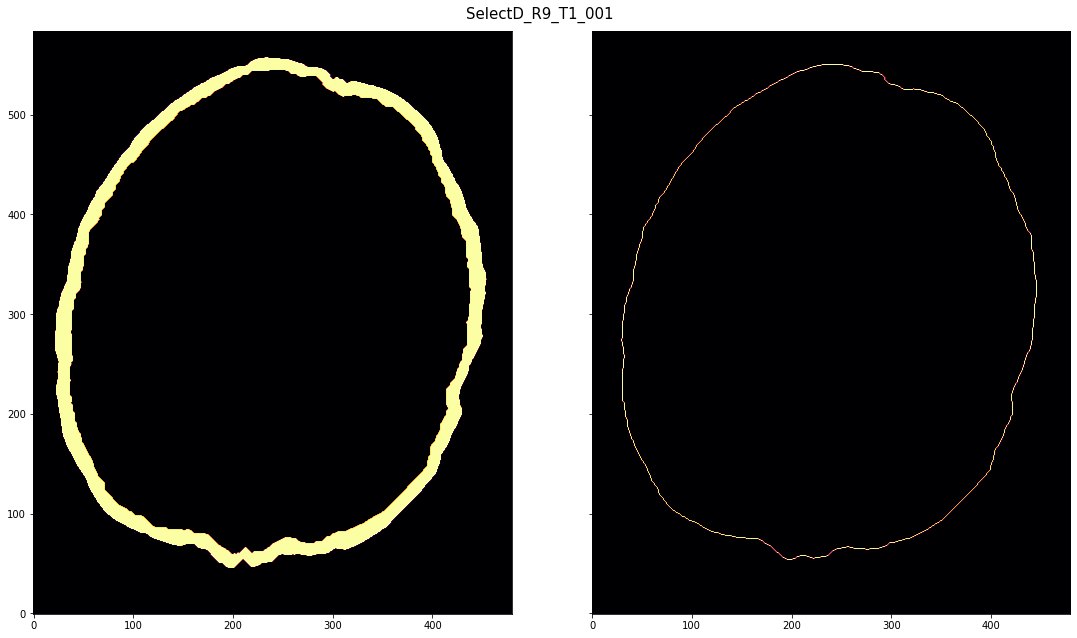

In [38]:
fig, ax = plt.subplots(1,2,figsize=(16,9), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()
i = 0
#ax[i].imshow(slc, cmap='inferno', origin='lower'); i+=1
ax[i].imshow(closed, cmap='inferno', origin='lower'); i+=1
#ax[i].imshow(dist, cmap='inferno', origin='lower'); i+=1
ax[i].imshow(ma, cmap='inferno', origin='lower'); i+=1

fig.suptitle(fname, fontsize=fs)
fig.tight_layout()

In [34]:
vx = np.median(dist[ma])
print(vx)
2*vx*resol

6.324555320336759


0.96006749762712